<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1022Two_attentions_additive_and_multiplicative_Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 加算型注意 と 内積型注意 の実習

- オリジナル [Sequence-to-sequence in Pytorch](https://github.com/b-etienne/Seq2seq-PyTorch)

<center>
<img src="https://komazawa-deep-learning.github.io/assets/2015Bahdanau_attention.jpg" width="33%">
<img src="https://komazawa-deep-learning.github.io/assets/2015Loung_fig3.svg" width="33%"><br/>
</center>

## 原著論文

* [加算型注意 Bahdanau 2014 Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
* [内積型注意 Loung 2015 Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)
* [Chan 2015 Listen, Attend and Spell](https://arxiv.org/abs/1508.01211)


# Seq2seq モデル

下図では，翻訳モデルで，ソース言語であるドイツ語から，ターゲット言語である英語への翻訳例である。
赤色の単語を符号化器に入力し， 英語の単語を順次出力する(青の矢印)。
すべての翻訳が青の h3 すなわち符号化器の最終時刻での中間層状態に依存していることに注意してください。

<center>
<img src="https://miro.medium.com/max/1000/1*zsOlGqCVTsEiWm--1n6Bng.png" width="49%"><br/>
ソース: http://cs224d.stanford.edu/lectures/CS224d-Lecture8.pdf
</center>

* まともに翻訳課題を例にとると，訓練に時間を要するので，今回は，おもちゃ問題で実行を確認します。
* 具体的には，系列反転課題を取り上げます。
* 数字の順唱課題，逆唱課題は WAIS 知能検査などにも取り上げられている短期記憶を測定する手法でもあります。
* この課題を元に，注意の役割を考えるのが，今回の課題となります。
* 具体的な課題は以下のとおりです

4 文字 "a", "b", "c", "d" からランダムに文字を選んで，任意の長さの系列を作成します。
このとき，符号化器に入力する文字列を，復号化器は反転することを学習するものとします。
<!-- 

Sequence-to-sequence neural network with attention. 
You can play with a toy dataset to test different configurations.
The toy dataset consists of batched (input, target) pairs, where the target is the reversed input.

### Hyper-parameters

You can tune the following parameters:

* decoder type (with or without Attention)
* encoder type (with or without downsampling, with or without preprocessing layers)
* the encoder's hidden dimension
* the number of recurrent layers in the encoder
* the encoder dropout
* the bidirectionality of the encoder
* the decoder's hidden dimension
* the number of recurrent layers in the decoder
* the decoder dropout
* the bidirectionality of the decoder
* batch size
* the type of attention used

 -->

# 1. データセットの作成

PyTorch で用いるデータセット `torch.utils.data.Dataset` を自作する場合，最低限 3 つの関数をクラス内で定義します。
1. `__init__()` 初期のための関数
2. `__len__()` データセットのサイズを返す関数
3. `__getitems__()` 数値を引数にとり，その数値に該当するデータを取り出して返す関数

In [1]:
import numpy as np
import os
import editdistance
from random import choice, randrange
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

import torch
from torch.utils import data

class ToyDataset(data.Dataset):
    """
    https://talbaumel.github.io/blog/attention/
    """
    def __init__(self, min_length=5, max_length=20, type='train'):
        self.SOS = "<s>"                       # 系列の始まりを表す特殊文字を定義 SOS は スタート(start) オブ(of) シーケンス(sequence) の頭文字
        self.EOS = "</s>"                      # 系列の終わりを表す特殊文字を定義 EOS は エンド(end) オブ(of) シーケンス(sequnence) の頭文字
        self.characters = list("abcd")         # 課題に使用する文字を定義
        self.int2char = list(self.characters)  # 文字列を数字に変換するためのリスト
        self.char2int = {c: i+3 for i, c in enumerate(self.characters)} # 文字列を数字に変換するための辞書
        #print(self.char2int)
        self.VOCAB_SIZE = len(self.characters)
        self.min_length = min_length
        self.max_length = max_length
        if type == 'train':
            self.set = [self._sample() for _ in range(3000)]
        else:
            self.set = [self._sample() for _ in range(300)]

    def __len__(self):
        return len(self.set)

    def __getitem__(self, item):
        return self.set[item]

    def _sample(self):
        random_length = randrange(self.min_length, self.max_length)                      # ランダムサンプリングする文字列長を一つランダムに選ぶ
        random_char_list = [choice(self.characters[:-1]) for _ in range(random_length)]  # 選んだ文字列長分だけ文字をランダムサンプリングする
        random_string = ''.join(random_char_list)                                        # 上で選んだ文字列を random_string として保存
        a = np.array([self.char2int.get(x) for x in random_string])                      # 文字列を数値に変換
        b = np.array([self.char2int.get(x) for x in random_string[::-1]] + [2])          # 文字列を逆向きにする
        x = np.zeros((random_length, self.VOCAB_SIZE)) # 文字列長 掛ける アルファベット文字数の行列を作って 0 で初期化した配列を x とする
        x[np.arange(random_length), a-3] = 1           # 初期化した x に文字列に該当する要素を 1 に変換 ワンホット表現にしないといけませんので

        return x, b


In [2]:
dataset = ToyDataset(5, 15)
print(f'データセットのサイズ: {dataset.__len__()}')
print(f'データセットから，試しに一つデータを取り出してみる: \n{dataset.__getitem__(5)}')
print(f'データセットから一つランダムサンプリングしてみる: \n{dataset._sample()}')

データセットのサイズ: 3000
データセットから，試しに一つデータを取り出してみる: 
(array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]]), array([5, 4, 5, 5, 4, 4, 4, 5, 5, 3, 5, 5, 4, 2]))
データセットから一つランダムサンプリングしてみる: 
(array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]]), array([3, 3, 5, 4, 4, 3, 5, 4, 4, 4, 5, 3, 5, 2]))


* 以下の 3 つのセルは下請け作業用ですので，単純に実行してください。
* 定義だけなので，時間はかかりません

In [3]:
# utils/misc.py
#import librosa
EOS_TOKEN = '</s>'

def check_size(tensor, *args):
    size = [a for a in args]
    assert tensor.size() == torch.Size(size), tensor.size()

In [4]:
# utils/data_generator.py
from torch.utils import data
from itertools import zip_longest

def pad_tensor(vec, pad, value=0, dim=0):
    """
    args:
        vec - tensor to pad
        pad - the size to pad to
        dim - dimension to pad

    return:
        a new tensor padded to 'pad' in dimension 'dim'
    """
    pad_size = pad - vec.shape[0]

    if len(vec.shape) == 2:
        zeros = torch.ones((pad_size, vec.shape[-1])) * value
    elif len(vec.shape) == 1:
        zeros = torch.ones((pad_size,)) * value
    else:
        raise NotImplementedError
    return torch.cat([torch.Tensor(vec), zeros], dim=dim)



def pad_collate(batch, values=(0, 0), dim=0):
    """
    args:
        batch - list of (tensor, label)

    reutrn:
        xs - a tensor of all examples in 'batch' after padding
        ys - a LongTensor of all labels in batch
        ws - a tensor of sequence lengths
    """
    sequence_lengths = torch.Tensor([int(x[0].shape[dim]) for x in batch])
    sequence_lengths, xids = sequence_lengths.sort(descending=True)
    target_lengths = torch.Tensor([int(x[1].shape[dim]) for x in batch])
    target_lengths, yids = target_lengths.sort(descending=True)
    # find longest sequence
    src_max_len = max(map(lambda x: x[0].shape[dim], batch))
    tgt_max_len = max(map(lambda x: x[1].shape[dim], batch))
    # pad according to max_len
    batch = [(pad_tensor(x, pad=src_max_len, dim=dim), pad_tensor(y, pad=tgt_max_len, dim=dim)) for (x, y) in batch]

    # stack all
    xs = torch.stack([x[0] for x in batch], dim=0)
    ys = torch.stack([x[1] for x in batch]).int()
    xs = xs[xids]
    ys = ys[yids]
    return xs, ys, sequence_lengths.int(), target_lengths.int()


In [5]:
# models/helpers.py
import torch

def mask_3d(inputs, seq_len, mask_value=0.):
    batches = inputs.size()[0]
    assert batches == len(seq_len)
    max_idx = max(seq_len)
    for n, idx in enumerate(seq_len):
        if idx < max_idx.item():
            if len(inputs.size()) == 3:
                inputs[n, idx.int():, :] = mask_value
            else:
                assert len(inputs.size()) == 2, "The size of inputs must be 2 or 3, received {}".format(inputs.size())
                inputs[n, idx.int():] = mask_value
    return inputs


def skip_add_pyramid(x, seq_len, skip_add="add"):
    if len(x.size()) == 2:
        x = x.unsqueeze(0)
    x_len = x.size()[1] // 2
    even = x[:, torch.arange(0, x_len*2-1, 2).long(), :]
    odd = x[:, torch.arange(1, x_len*2, 2).long(), :]
    if skip_add == "add":
        return (even+odd) / 2, ((seq_len) / 2).int()
    else:
        return even, (seq_len / 2).int()



# 2. 符号化器の定義

* 符号化器は seq2seq モデルで，与えられた系列を「聞いて覚える」部分です。
* 以下で定義するリカレントニューラルネットワークです。
* 実習としては，SNN, GRU, LSTM などを選ぶことができます。
* また，好きなものを選択可能) で構成されており， その前に畳み込み層や密な層を加えることができます。

符号化器にデータを入力する前に `pack_padded_sequence` と `pad_packed_sequence` ヘルパーを使っています。
データのバッチを使用しているので， バッチ内の各項目 (系列) は異なる長さを持ちますが，このバッチ内の全系列を，最長の系列の長さまで 0 で埋めることをしています。


In [6]:
# models/encoders.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable


class EncoderRNN(nn.Module):
    def __init__(self, config):
        super(EncoderRNN, self).__init__()
        self.input_size = config["n_channels"]
        self.hidden_size = config["encoder_hidden"]
        self.layers = config.get("encoder_layers", 1)
        self.dnn_layers = config.get("encoder_dnn_layers", 0)
        self.dropout = config.get("encoder_dropout", 0.)
        self.bi = config.get("bidirectional_encoder", False)
        if self.dnn_layers > 0:
            for i in range(self.dnn_layers):
                self.add_module('dnn_' + str(i), nn.Linear(
                    in_features=self.input_size if i == 0 else self.hidden_size,
                    out_features=self.hidden_size
                ))
        gru_input_dim = self.input_size if self.dnn_layers == 0 else self.hidden_size
        self.rnn = nn.GRU(
            gru_input_dim,
            self.hidden_size,
            self.layers,
            dropout=self.dropout,
            bidirectional=self.bi,
            batch_first=True)
        self.gpu = config.get("gpu", True)

    def run_dnn(self, x):
        for i in range(self.dnn_layers):
            x = F.relu(getattr(self, 'dnn_'+str(i))(x))
        return x

    def forward(self, inputs, hidden, input_lengths):
        if self.dnn_layers > 0:
            inputs = self.run_dnn(inputs)
        x = pack_padded_sequence(inputs, input_lengths, batch_first=True)
        output, state = self.rnn(x, hidden)
        output, _ = pad_packed_sequence(output, batch_first=True, padding_value=0.)

        if self.bi:
            output = output[:, :, :self.hidden_size] + output[:, :, self.hidden_size:]
        return output, state

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(2 if self.bi else 1, batch_size, self.hidden_size))
        if self.gpu:
            h0 = h0.cuda()
        return h0


class EncoderPyRNN(nn.Module):
    def __init__(self, config):
        super(EncoderPyRNN, self).__init__()
        self.input_size = config["n_channels"]
        self.hidden_size = config["encoder_hidden"]
        self.n_layers = config.get("encoder_layers", 1)
        self.dnn_layers = config.get("encoder_dnn_layers", 0)
        self.dropout = config.get("encoder_dropout", 0.)
        self.bi = config.get("bidirectional_encoder", False)
        self.skip_add = config.get("skip_add_pyramid_encoder", "add")
        self.gpu = config.get("gpu", True)

        if self.dnn_layers > 0:
            for i in range(self.dnn_layers):
                self.add_module('dnn_' + str(i), nn.Linear(
                    in_features=self.input_size if i == 0 else self.hidden_size,
                    out_features=self.hidden_size
                ))
        gru_input_dim = self.input_size if self.dnn_layers == 0 else self.hidden_size

        for i in range(self.n_layers):
            self.add_module('pRNN_' + str(i), nn.GRU(
                input_size=gru_input_dim if i == 0 else self.hidden_size,
                hidden_size=self.hidden_size,
                dropout=self.dropout,
                bidirectional=self.bi,
                batch_first=True))

    def run_dnn(self, x):
        for i in range(self.dnn_layers):
            x = F.relu(getattr(self, 'dnn_'+str(i))(x))
        return x

    def run_pRNN(self, inputs, hidden, input_lengths):
        """

        :param input: (batch, seq_len, input_size)
        :param hidden: (num_layers * num_directions, batch, hidden_size)
        :return:
        """
        for i in range(self.n_layers):
            x = pack_padded_sequence(inputs, input_lengths, batch_first=True)
            output, hidden = getattr(self, 'pRNN_'+str(i))(x, hidden)
            output, _ = pad_packed_sequence(output, batch_first=True, padding_value=0.)
            hidden = hidden

            if self.bi:
                output = output[:, :, :self.hidden_size] + output[:, :, self.hidden_size:]

            if i < self.n_layers - 1:
                inputs, input_lengths = skip_add_pyramid(output, input_lengths, self.skip_add)

        return output, hidden, input_lengths

    def forward(self, inputs, hidden, input_lengths):
        if self.dnn_layers > 0:
            inputs = self.run_dnn(inputs)

        outputs, hidden, input_lengths = self.run_pRNN(inputs, hidden, input_lengths)

        if self.bi:
            hidden = torch.sum(hidden, 0)

        return outputs, hidden, input_lengths

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(2 if self.bi else 1, batch_size, self.hidden_size))
        if self.gpu:
            h0 = h0.cuda()
        return h0


# 3. 復号化器の定義

* 復号化器は， 予測値を出力し，それをもとに損失値を計算します。
* 符号化器からの入力を受け取って，出力に変換します。
* このとき，以下のような 3 種類の復号化器を定義しています。
    1. バニラ復号化器
    2. Bahdanau 型注意付き復号化器
    3. Luong 型注意付き復号化器
    
* 注意つき復号化器は， 復号化器の出力を入力とし， どの部分に注目して予測を出力するかを決定します
* 注意なしのバニラモデルでは， 符号化器の最終時刻の隠れ層状態だけ使用して復号化を試みます。

* 復号化器に対する入力は，以下のものがあります
    1. 一時刻前の出力， (標的系列の次の文字，または前に出力された文字) 双方向 RNN を使ってる場合には，逆方向からも入力を受けます
    2. 隠れ層 (中間層) の状態
    3. 注意を使っているかどうかに応じたその他の引数


## 3.1 リカレントネットワーク復号化器

直下のセルでは以下の 3 つのクラスを定義しています

1. Seq2seq モデルのプロトタイプである リカレントニューラルネットワークによる復号化器のプロトタイプ
2. 加算型注意付き復号化器
3. 内積型注意付き復号化器

In [7]:
# models/decorders.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    """
    復号化器のプロトタイプ
    forward() 関数は，それぞれの実装ごとに定義するので，空の実装になっています
    """
    def __init__(self, config):
        super(Decoder, self).__init__()
        self.batch_size = config["batch_size"]
        self.hidden_size = config["decoder_hidden"]
        embedding_dim = config.get("embedding_dim", None)
        self.embedding_dim = embedding_dim if embedding_dim is not None else self.hidden_size
        self.embedding = nn.Embedding(config.get("n_classes", 32), self.embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(
            input_size=self.embedding_dim+self.hidden_size if config['decoder'].lower() == 'bahdanau' else self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=config.get("decoder_layers", 1),
            dropout=config.get("decoder_dropout", 0),
            bidirectional=config.get("bidirectional_decoder", False),
            batch_first=True)
        if config['decoder'] != "RNN":
            self.attention = Attention(
                self.batch_size,
                self.hidden_size,
                method=config.get("attention_score", "dot"),
                mlp=config.get("attention_mlp_pre", False))

        self.gpu = config.get("gpu", False)
        self.decoder_output_fn = F.log_softmax if config.get('loss', 'NLL') == 'NLL' else None

    def forward(self, **kwargs):
        """ Must be overrided """
        raise NotImplementedError


class RNNDecoder(Decoder):
    def __init__(self, config):
        super(RNNDecoder, self).__init__(config)
        self.output_size = config.get("n_classes", 32)
        self.character_distribution = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, **kwargs):
        input = kwargs["input"]
        hidden = kwargs["hidden"]
        # RNN (Eq 7 paper)
        embedded = self.embedding(input).unsqueeze(0)
        rnn_input = torch.cat((embedded, hidden.unsqueeze(0)), 2)  # NOTE : Tf concats `lambda inputs, attention: array_ops.concat([inputs, attention], -1)`.
        # rnn_output, rnn_hidden = self.rnn(rnn_input.transpose(1, 0), hidden.unsqueeze(0))
        rnn_output, rnn_hidden = self.rnn(embedded.transpose(1, 0), hidden.unsqueeze(0))
        output = rnn_output.squeeze(1)
        output = self.character_distribution(output)

        if self.decoder_output_fn:
            output = self.decoder_output_fn(output, -1)

        return output, rnn_hidden.squeeze(0)


class BahdanauDecoder(Decoder):
    """ 
        Bahdanau 型の注意付き復号化器
    """

    def __init__(self, config):
        super(BahdanauDecoder, self).__init__(config)
        self.output_size = config.get("n_classes", 32)
        self.character_distribution = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, **kwargs):
        """
        :param input: [B]
        :param prev_context: [B, H]
        :param prev_hidden: [B, H]
        :param encoder_outputs: [B, T, H]
        :return: output (B), context (B, H), prev_hidden (B, H), weights (B, T)
        """

        input = kwargs["input"]
        prev_hidden = kwargs["prev_hidden"]
        encoder_outputs = kwargs["encoder_outputs"]
        seq_len = kwargs.get("seq_len", None)

        # 入力のチェック
        assert input.size() == torch.Size([self.batch_size])
        assert prev_hidden.size() == torch.Size([self.batch_size, self.hidden_size])

        # 注意の重み
        weights = self.attention.forward(prev_hidden, encoder_outputs, seq_len)  # B x T
        context = weights.unsqueeze(1).bmm(encoder_outputs).squeeze(1)           # [B x H]

        # 埋め込み層
        embedded = self.embedding(input).unsqueeze(0)
        assert embedded.size() == torch.Size([1, self.batch_size, self.embedding_dim])

        rnn_input = torch.cat((embedded, context.unsqueeze(0)), 2)
        outputs, hidden = self.rnn(rnn_input.transpose(1, 0), prev_hidden.unsqueeze(0)) # 1 x B x N, B x N

        # output = self.proj(torch.cat((outputs.squeeze(0), context), 1))
        output = self.character_distribution(outputs.squeeze(0))

        if self.decoder_output_fn:
            output = self.decoder_output_fn(output, -1)

        if len(output.size()) == 3:
            output = output.squeeze(1)

        return output, hidden.squeeze(0), weights


class LuongDecoder(Decoder):
    """
        Luong 型の注意付き復号化器
    """

    def __init__(self, config):
        super(LuongDecoder, self).__init__(config)
        self.output_size = config.get("n_classes", 32)
        self.character_distribution = nn.Linear(2*self.hidden_size, self.output_size)

    def forward(self, **kwargs):
        """
        :param input: [B]
        :param prev_context: [B, H]
        :param prev_hidden: [B, H]
        :param encoder_outputs: [B, T, H]
        :return: output (B, V), context (B, H), prev_hidden (B, H), weights (B, T)

        https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/contrib/seq2seq/python/ops/attention_wrapper.py
        TF says : Perform a step of attention-wrapped RNN.
        - Step 1: Mix the `inputs` and previous step's `attention` output via
          `cell_input_fn`.
        - Step 2: Call the wrapped `cell` with this input and its previous state.
        - Step 3: Score the cell's output with `attention_mechanism`.
        - Step 4: Calculate the alignments by passing the score through the
          `normalizer`.
        - Step 5: Calculate the context vector as the inner product between the
          alignments and the attention_mechanism's values (memory).
        - Step 6: Calculate the attention output by concatenating the cell output
          and context through the attention layer (a linear layer with
          `attention_layer_size` outputs).
        Args:
          inputs: (Possibly nested tuple of) Tensor, the input at this time step.
          state: An instance of `AttentionWrapperState` containing
            tensors from the previous time step.
        Returns:
          A tuple `(attention_or_cell_output, next_state)`, where:
          - `attention_or_cell_output` depending on `output_attention`.
          - `next_state` is an instance of `AttentionWrapperState`
             containing the state calculated at this time step.
        Raises:
          TypeError: If `state` is not an instance of `AttentionWrapperState`.

        """
        input = kwargs["input"]
        prev_hidden = kwargs["prev_hidden"]
        encoder_outputs = kwargs["encoder_outputs"]
        seq_len = kwargs.get("seq_len", None)

        # RNN 式(7)
        embedded = self.embedding(input).unsqueeze(1) # [B, H]
        prev_hidden = prev_hidden.unsqueeze(0)
        # rnn_input = torch.cat((embedded, prev_context), -1) 
        # NOTE : Tf concats `lambda inputs, attention: array_ops.concat([inputs, attention], -1)`.
        # rnn_output, hidden = self.rnn(rnn_input.transpose(1, 0), prev_hidden)
        rnn_output, hidden = self.rnn(embedded, prev_hidden)
        rnn_output = rnn_output.squeeze(1)

        # Attention weights 式(6)
        weights = self.attention.forward(rnn_output, encoder_outputs, seq_len) # B x T
        context = weights.unsqueeze(1).bmm(encoder_outputs).squeeze(1)  # [B x N]

        # Projection 式 (8)
        # Don't apply tanh on outputs, it fucks everything up
        output = self.character_distribution(torch.cat((rnn_output, context), 1))

        # Apply log softmax if loss is NLL
        if self.decoder_output_fn:
            output = self.decoder_output_fn(output, -1)

        if len(output.size()) == 3:
            output = output.squeeze(1)

        return output, hidden.squeeze(0), weights
    

## 3.2 注意の得点化

* `AttentionDecoder` の心臓部には `Attention` モジュールがあります。
* このモジュールにより， さまざまな注意スコアを計算することができます。
* 内積型 (Luong) と 加算型 (Bahdanau) の 2 種類がある。

* そこで テンソル間 (キーとクエリと呼ばれることもある) の類似性を計算するオプションを持つカスタム Attention モジュールを定義しています。 
* スコアは正規化され， 類似性スコアのソフトマックス関数を用いて確率を定義します。 
* このモジュールは， 重み計算でパディングをマスクするために， カスタムの mask_3d 関数を使用します。

In [8]:
class Attention(nn.Module):
    """
    Inputs:
        last_hidden: (batch_size, hidden_size)
        encoder_outputs: (batch_size, max_time, hidden_size)
    Returns:
        attention_weights: (batch_size, max_time)
    """
    def __init__(self, batch_size, hidden_size, method="dot", mlp=False):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        if method == 'dot':
            pass
        elif method == 'general':
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == "concat":
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
            self.va = nn.Parameter(torch.FloatTensor(batch_size, hidden_size))
        elif method == 'bahdanau':
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
            self.Ua = nn.Linear(hidden_size, hidden_size, bias=False)
            self.va = nn.Parameter(torch.FloatTensor(batch_size, hidden_size))
        else:
            raise NotImplementedError

        self.mlp = mlp
        if mlp:
            self.phi = nn.Linear(hidden_size, hidden_size, bias=False)
            self.psi = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, last_hidden, encoder_outputs, seq_len=None):
        batch_size, seq_lens, _ = encoder_outputs.size()
        if self.mlp:
            last_hidden = self.phi(last_hidden)
            encoder_outputs = self.psi(encoder_outputs)

        attention_energies = self._score(last_hidden, encoder_outputs, self.method)
        # attn_energies = Variable(torch.zeros(batch_size, seq_lens))  # B x S

        if seq_len is not None:
            attention_energies = mask_3d(attention_energies, seq_len, -float('inf'))

        return F.softmax(attention_energies, -1)

    def _score(self, last_hidden, encoder_outputs, method):
        """
        Computes an attention score
        :param last_hidden: (batch_size, hidden_dim)
        :param encoder_outputs: (batch_size, max_time, hidden_dim)
        :param method: str (`dot`, `general`, `concat`)
        :return:
        """

        # assert last_hidden.size() == torch.Size([batch_size, self.hidden_size]), last_hidden.size()
        assert encoder_outputs.size()[-1] == self.hidden_size

        if method == 'dot':
            last_hidden = last_hidden.unsqueeze(-1)
            return encoder_outputs.bmm(last_hidden).squeeze(-1)

        elif method == 'general':
            x = self.Wa(last_hidden)
            x = x.unsqueeze(-1)
            return encoder_outputs.bmm(x).squeeze(-1)

        elif method == "concat":
            x = last_hidden.unsqueeze(1)
            #x = F.tanh(self.Wa(torch.cat((x, encoder_outputs), 1)))
            x = torch.tanh(self.Wa(torch.cat((x, encoder_outputs), 1)))
            return x.bmm(self.va.unsqueeze(2)).squeeze(-1)

        elif method == "bahdanau":
            x = last_hidden.unsqueeze(1)
            #out = F.tanh(self.Wa(x) + self.Ua(encoder_outputs))
            out = torch.tanh(self.Wa(x) + self.Ua(encoder_outputs))
            return out.bmm(self.va.unsqueeze(2)).squeeze(-1)

        else:
            raise NotImplementedError

    def extra_repr(self):
        return 'score={}, mlp_preprocessing={}'.format(
            self.method, self.mlp)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.autograd import Variable

class Seq2Seq(nn.Module):
    """Sequence to sequence モデルのクラス"""

    def __init__(self, config):
        super(Seq2Seq, self).__init__()
        self.SOS = config.get("start_index", 1),
        self.vocab_size = config.get("n_classes", 32)
        self.batch_size = config.get("batch_size", 1)
        self.sampling_prob = config.get("sampling_prob", 0.)
        self.gpu = config.get("gpu", False)

        # Encoder
        if config["encoder"] == "PyRNN":
            self._encoder_style = "PyRNN"
            self.encoder = EncoderPyRNN(config)
        else:
            self._encoder_style = "RNN"
            self.encoder = EncoderRNN(config)

        # Decoder
        self.use_attention = config["decoder"] != "RNN"
        if config["decoder"] == "Luong":
            self.decoder = LuongDecoder(config)
        elif config["decoder"] == "Bahdanau":
            self.decoder = BahdanauDecoder(config)
        else:
            self.decoder = RNNDecoder(config)

        if config.get('loss') == 'cross_entropy':
            self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
            config['loss'] = 'cross_entropy'
        else:
            self.loss_fn = torch.nn.NLLLoss(ignore_index=0)
            config['loss'] = 'NLL'
        self.loss_type = config['loss']
        #print(config)

    def encode(self, x, x_len):

        batch_size = x.size()[0]
        init_state = self.encoder.init_hidden(batch_size)
        if self._encoder_style == "PyRNN":
            encoder_outputs, encoder_state, input_lengths = self.encoder.forward(x, init_state, x_len)
        else:
            encoder_outputs, encoder_state = self.encoder.forward(x, init_state, x_len)

        assert encoder_outputs.size()[0] == self.batch_size, encoder_outputs.size()
        assert encoder_outputs.size()[-1] == self.decoder.hidden_size

        if self._encoder_style == "PyRNN":
            return encoder_outputs, encoder_state.squeeze(0), input_lengths
        return encoder_outputs, encoder_state.squeeze(0)

    def decode(self, encoder_outputs, encoder_hidden, targets, targets_lengths, input_lengths):
        """
        Args:
            encoder_outputs: (B, T, H)
            encoder_hidden: (B, H)
            targets: (B, L)
            targets_lengths: (B)
            input_lengths: (B)
        Vars:
            decoder_input: (B)
            decoder_context: (B, H)
            hidden_state: (B, H)
            attention_weights: (B, T)
        Outputs:
            alignments: (L, T, B)
            logits: (B*L, V)
            labels: (B*L)
        """

        batch_size = encoder_outputs.size()[0]
        max_length = targets.size()[1]
        # decoder_attns = torch.zeros(batch_size, MAX_LENGTH, MAX_LENGTH)
        decoder_input = Variable(torch.LongTensor([self.SOS] * batch_size)).squeeze(-1)
        decoder_context = encoder_outputs.transpose(1, 0)[-1]
        decoder_hidden = encoder_hidden

        alignments = Variable(torch.zeros(max_length, encoder_outputs.size(1), batch_size))
        logits = Variable(torch.zeros(max_length, batch_size, self.decoder.output_size))

        if self.gpu:
            decoder_input = decoder_input.cuda()
            decoder_context = decoder_context.cuda()
            logits = logits.cuda()

        for t in range(max_length):
            # The decoder accepts, at each time step t :
            # - an input, [B]
            # - a context, [B, H]
            # - an hidden state, [B, H]
            # - encoder outputs, [B, T, H]

            check_size(decoder_input, self.batch_size)
            check_size(decoder_hidden, self.batch_size, self.decoder.hidden_size)
            # The decoder outputs, at each time step t :
            # - an output, [B]
            # - a context, [B, H]
            # - an hidden state, [B, H]
            # - weights, [B, T]

            if self.use_attention:
                check_size(decoder_context, self.batch_size, self.decoder.hidden_size)
                outputs, decoder_hidden, attention_weights = self.decoder.forward(
                    input=decoder_input.long(),
                    prev_hidden=decoder_hidden,
                    encoder_outputs=encoder_outputs,
                    seq_len=input_lengths)
                alignments[t] = attention_weights.transpose(1, 0)
            else:
                outputs, hidden = self.decoder.forward(
                    input=decoder_input.long(),
                    hidden=decoder_hidden)

            # print(outputs[0])
            logits[t] = outputs

            use_teacher_forcing = random.random() > self.sampling_prob

            if use_teacher_forcing and self.training:
                decoder_input = targets[:, t]

            # SCHEDULED SAMPLING
            # We use the target sequence at each time step which we feed in the decoder
            else:
                # TODO Instead of taking the direct one-hot prediction from the previous time step as the original paper
                # does, we thought it is better to feed the distribution vector as it encodes more information about
                # prediction from previous step and could reduce bias.
                topv, topi = outputs.data.topk(1)
                decoder_input = topi.squeeze(-1).detach()


        labels = targets.contiguous().view(-1)

        if self.loss_type == 'NLL': # ie softmax already on outputs
            mask_value = -float('inf')
            print(torch.sum(logits, dim=2))
        else:
            mask_value = 0

        logits = mask_3d(logits.transpose(1, 0), targets_lengths, mask_value)
        logits = logits.contiguous().view(-1, self.vocab_size)

        return logits, labels.long(), alignments

    @staticmethod
    def custom_loss(logits, labels):

        # create a mask by filtering out all tokens that ARE NOT the padding token
        tag_pad_token = 0
        mask = (labels > tag_pad_token).float()

        # count how many tokens we have
        nb_tokens = int(torch.sum(mask).data[0])

        # pick the values for the label and zero out the rest with the mask
        logits = logits[range(logits.shape[0]), labels] * mask

        # compute cross entropy loss which ignores all <PAD> tokens
        ce_loss = -torch.sum(logits) / nb_tokens

        return ce_loss

    def step(self, batch):
        x, y, x_len, y_len = batch
        if self.gpu:
            x = x.cuda()
            y = y.cuda()
            x_len = x_len.cuda()
            y_len = y_len.cuda()

        if self._encoder_style == "PyRNN":
            encoder_out, encoder_state, x_len = self.encode(x, x_len)
        else:
            encoder_out, encoder_state = self.encode(x, x_len)
        logits, labels, alignments = self.decode(encoder_out, encoder_state, y, y_len, x_len)
        return logits, labels, alignments

    def loss(self, batch):
        logits, labels, alignments = self.step(batch)
        loss = self.loss_fn(logits, labels)
        # loss2 = self.custom_loss(logits, labels)
        return loss, logits, labels, alignments


In [10]:
def train(model, optimizer, train_loader, state):
    epoch, n_epochs, train_steps = state

    losses = []
    cers = []

    # t = tqdm.tqdm(total=min(len(train_loader), train_steps))
    t = tqdm.tqdm(train_loader)
    model.train()

    for batch in t:
        t.set_description(f"エポック {epoch+1:.0f}/{n_epochs:.0f} (train={model.training})")
        loss, _, _, _ = model.loss(batch)
        losses.append(loss.item())

        optimizer.zero_grad() # 勾配のリセット
        loss.backward()       # 勾配の計算
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2) # 勾配爆発抑制のため
        optimizer.step()      # 計算した勾配に基づいて，パラメータの更新

        t.set_postfix(損失=f'{loss.item():05.3f}', 平均損失=f'{np.mean(losses):05.3f}')
        t.update()

    return model, optimizer
    # print(" 訓練終了: 損失:{np.mean(losses):05.3f} , cer={np.mean(cers)*100:03.1f}")


def evaluate(model, eval_loader):

    losses = []
    accs = []

    t = tqdm.tqdm(eval_loader)
    model.eval()

    with torch.no_grad():
        for batch in t:
            #t.set_description(" 評価... (train={})".format(model.training))
            loss, logits, labels, alignments = model.loss(batch)
            preds = logits.detach().cpu().numpy()
            # acc = np.sum(np.argmax(preds, -1) == labels.detach().cpu().numpy()) / len(preds)
            acc = 100 * editdistance.eval(np.argmax(preds, -1), labels.detach().cpu().numpy()) / len(preds)
            losses.append(loss.item())
            accs.append(acc)
            #t.set_postfix(avg_acc='{:05.3f}'.format(np.mean(accs)), 平均損失='{:05.3f}'.format(np.mean(losses)))
            t.set_postfix(平均精度=f'{np.mean(accs):05.3f}', 平均損失='{np.mean(losses):05.3f}')
            t.update()
        align = alignments.detach().cpu().numpy()[:, :, 0]

    # Uncomment if you want to visualise weights
    fig, ax = plt.subplots(1, 1)
    ax.pcolormesh(align)
    fig.savefig("att__.png")
    print(f"  最終評価 : 平均損失値 {np.mean(losses):05.3f}, 平均精度 {np.mean(accs):03.1f}")
    return {'loss': np.mean(losses), 'cer': np.mean(accs)*100}


In [11]:
# 各モデルのパラメータ，変更して実習を行います
vanilla_setup = {
    "decoder": "RNN",
    "encoder": "RNN",
    "n_channels": 4,
    "encoder_hidden": 64,
    "encoder_layers": 1,
    "encoder_dropout": 0.0,
    "bidirectional_encoder": False,
    "decoder_hidden": 64,
    "decoder_layers": 1,
    "decoder_dropout": 0.1,
    "bidirectional_decoder": False,
    "n_classes": 7,
    "batch_size": 4,
    "sampling_prob": 0.0,
    "embedding_dim": 64,
    "attention_score": "general",
    "attention_mlp_pre": False,
    "learning_rate": 0.001,
    "gpu": False,
    "loss": "cross_entropy"
}

bahdanau_setup = {
    "decoder": "Bahdanau",
    "encoder": "RNN",
    "n_channels": 4,
    "encoder_hidden": 64,
    "encoder_layers": 1,
    "encoder_dropout": 0.0,
    "bidirectional_encoder": False,
    "decoder_hidden": 64,
    "decoder_layers": 1,
    "decoder_dropout": 0.1,
    "bidirectional_decoder": False,
    "n_classes": 7,
    "batch_size": 4,
    "sampling_prob": 0.0,
    "embedding_dim": 64,
    "attention_score": "bahdanau",
    "attention_mlp_pre": False,
    "learning_rate": 0.001,
    "gpu": False,
    "loss": "cross_entropy"
}

luong_setup = {
    "decoder": "Luong",
    "encoder": "RNN",
    "n_channels": 4,
    "encoder_hidden": 64,
    "encoder_layers": 1,
    "encoder_dropout": 0.0,
    "bidirectional_encoder": False,
    "decoder_hidden": 64,
    "decoder_layers": 1,
    "decoder_dropout": 0.1,
    "bidirectional_decoder": False,
    "n_classes": 7,
    "batch_size": 4,
    "sampling_prob": 0.0,
    "embedding_dim": 64,
    "attention_score": "general",
    "attention_mlp_pre": False,
    "learning_rate": 0.001,
    "gpu": False,
    "loss": "cross_entropy"
}

In [12]:
def run(config=vanilla_setup, 
        n_epochs=20, 
        train_size=28000):

    USE_CUDA = torch.cuda.is_available()
    config["gpu"] = torch.cuda.is_available()

    dataset = ToyDataset(5, 15)
    eval_dataset = ToyDataset(5, 15, type='eval')
    #BATCHSIZE = 30
    BATCHSIZE = config['batch_size']
    
    train_loader = data.DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, collate_fn=pad_collate, drop_last=True)
    eval_loader = data.DataLoader(eval_dataset, batch_size=BATCHSIZE, shuffle=False, collate_fn=pad_collate,
                                  drop_last=True)
    config["batch_size"] = BATCHSIZE

    model = Seq2Seq(config)   # モデルの設定
    if USE_CUDA:
        model = model.cuda()  # GPU の設定

    # 最適化手法の設定 ここでは Adam を指定しています。SGD でも RMSprop でもお好きなものを指定してください
    optimizer = torch.optim.Adam(model.parameters(), lr=config.get("learning_rate", .001))

    print('=== モデルの詳細===')
    print(model)
    for k, v in sorted(config.items(), key=lambda i: i[0]):
        # print(" (" + k + ") : " + str(v))
        print(f'{k}: {str(v)}')

    print("=== パラメータの初期化 ===")
    for name, param in model.named_parameters():
        if 'bias' in name:
            torch.nn.init.constant_(param, 0.0)
        elif 'weight' in name:
            torch.nn.init.xavier_normal_(param)

    # 実際の訓練を n_epochs 回繰り返す
    for epoch in range(n_epochs):
        run_state = (epoch, n_epochs, train_size)

        # Train needs to return model and optimizer, otherwise the model keeps restarting from zero at every epoch
        model, optimizer = train(model, optimizer, train_loader, run_state)
        evaluate(model, eval_loader)

        # モデルの保存は実装していません


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


=== モデルの詳細===
Seq2Seq(
  (encoder): EncoderRNN(
    (rnn): GRU(4, 64, batch_first=True)
  )
  (decoder): LuongDecoder(
    (embedding): Embedding(7, 64, padding_idx=0)
    (rnn): GRU(64, 64, batch_first=True, dropout=0.1)
    (attention): Attention(
      score=general, mlp_preprocessing=False
      (Wa): Linear(in_features=64, out_features=64, bias=False)
    )
    (character_distribution): Linear(in_features=128, out_features=7, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
attention_mlp_pre: False
attention_score: general
batch_size: 4
bidirectional_decoder: False
bidirectional_encoder: False
decoder: Luong
decoder_dropout: 0.1
decoder_hidden: 64
decoder_layers: 1
embedding_dim: 64
encoder: RNN
encoder_dropout: 0.0
encoder_hidden: 64
encoder_layers: 1
gpu: False
learning_rate: 0.001
loss: cross_entropy
n_channels: 4
n_classes: 7
sampling_prob: 0.0
=== パラメータの初期化 ===


100%|██████████████████████| 75/75 [00:00<00:00, 120.15it/s, 平均損失={np.mean(losses):05.3f}, 平均精度=1.719], ?it/s]


  最終評価 : 平均損失値 0.194, 平均精度 1.7


100%|██████████████████████| 75/75 [00:00<00:00, 127.27it/s, 平均損失={np.mean(losses):05.3f}, 平均精度=0.784], ?it/s]


  最終評価 : 平均損失値 0.111, 平均精度 0.8


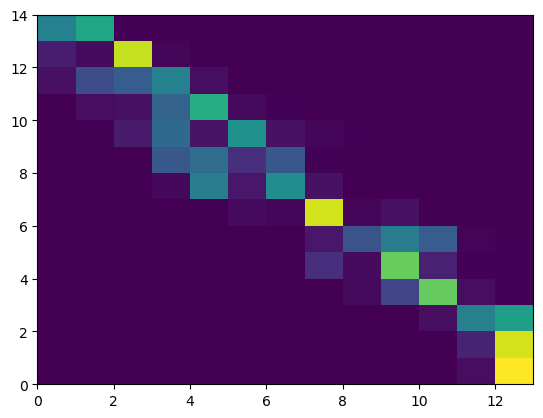

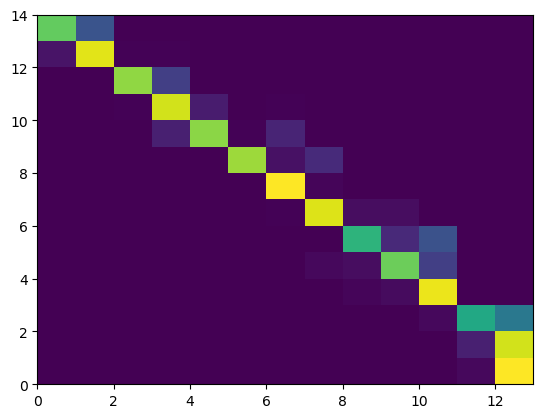

In [13]:
setup = vanilla_setup
setup = bahdanau_setup
setup = luong_setup

run(config=setup, n_epochs=2, train_size=10000)


In [ ]:
!pwd